In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
import pandas as pd
import os

# Directorio base donde están los archivos
base_path = r'C:\Users\s1246678\Downloads'

# Diccionario para almacenar todos los datasets
datasets = {}

# Lista de archivos a importar
archivos = {
    'datos_clientes': 'datos_clientes - dataset.csv',
    'diccionario': 'diccionario.xlsx', 
    'facturacion': 'facturacion_duracion_llamadas_trimestre - f.csv',
    'segmentos': 'segmentos.csv',
    'cliente_planes': 'cliente_planes - cliente_cdp.csv'
}

# Importar cada archivo
for nombre, archivo in archivos.items():
    ruta_completa = os.path.join(base_path, archivo)
    
    try:
        if archivo.endswith('.xlsx'):
            datasets[nombre] = pd.read_excel(ruta_completa)
        else:
            datasets[nombre] = pd.read_csv(ruta_completa)
        
        print(f"✅ {nombre}: {datasets[nombre].shape} - Importado exitosamente")
        
    except FileNotFoundError:
        print(f"❌ {nombre}: Archivo no encontrado - {archivo}")
    except Exception as e:
        print(f"⚠️ {nombre}: Error al importar - {str(e)}")

print("\n" + "="*50)
print("RESUMEN DE DATASETS IMPORTADOS:")
print("="*50)

for nombre, df in datasets.items():
    print(f"\n📊 {nombre.upper()}:")
    print(f"   Dimensiones: {df.shape}")
    print(f"   Columnas: {list(df.columns)}")

✅ datos_clientes: (10901, 7) - Importado exitosamente
⚠️ diccionario: Error al importar - Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.
✅ facturacion: (10900, 3) - Importado exitosamente
✅ segmentos: (1389, 4) - Importado exitosamente
✅ cliente_planes: (32618, 3) - Importado exitosamente

RESUMEN DE DATASETS IMPORTADOS:

📊 DATOS_CLIENTES:
   Dimensiones: (10901, 7)
   Columnas: ['user_id', 'nro_cliente', 'install_time', 'platform', 'country_region', 'city', 'gender']

📊 FACTURACION:
   Dimensiones: (10900, 3)
   Columnas: ['nro_cliente', 'sum_fact', 'sum_duracion']

📊 SEGMENTOS:
   Dimensiones: (1389, 4)
   Columnas: ['user_id', 'target_churn_indicator', 'range_group', 'n_previous_registers']

📊 CLIENTE_PLANES:
   Dimensiones: (32618, 3)
   Columnas: ['mes', 'nro_cliente', 'Plan_mes']


In [27]:
# Contar cambios de plan por cliente

CLIENTE_PLANES = datasets['cliente_planes'].copy()
cambios_plan = CLIENTE_PLANES.groupby('nro_cliente')['Plan_mes'].nunique()

# Clientes con al menos un cambio (más de 1 plan único)
clientes_con_cambios = cambios_plan[cambios_plan > 1]

# Resultado
num_clientes_cambios = len(clientes_con_cambios)
print(f"Clientes con al menos un cambio de plan: {num_clientes_cambios}")

# Estadísticas adicionales
print(f"Total de clientes únicos: {CLIENTE_PLANES['nro_cliente'].nunique()}")
print(f"Porcentaje con cambios: {(num_clientes_cambios / CLIENTE_PLANES['nro_cliente'].nunique()) * 100:.2f}%")

Clientes con al menos un cambio de plan: 5847
Total de clientes únicos: 10900
Porcentaje con cambios: 53.64%


In [28]:
# Primero, obtener los datasets necesarios
CLIENTE_PLANES = datasets['cliente_planes']
DATOS_CLIENTES = datasets['datos_clientes']

# Calcular cambios de plan por cliente
cambios_por_cliente = CLIENTE_PLANES.groupby('nro_cliente')['Plan_mes'].nunique().reset_index()
cambios_por_cliente.columns = ['nro_cliente', 'num_planes_unicos']
cambios_por_cliente['tiene_cambios'] = cambios_por_cliente['num_planes_unicos'] > 1
cambios_por_cliente['num_cambios'] = cambios_por_cliente['num_planes_unicos'] - 1

# Combinar con datos de clientes para obtener country_region
analisis_region = DATOS_CLIENTES[['nro_cliente', 'country_region']].merge(
    cambios_por_cliente, 
    on='nro_cliente', 
    how='inner'
)

print("📊 ANÁLISIS POR REGIÓN:")
print("="*50)

# 1. Porcentaje de clientes con cambios por región
resumen_region = analisis_region.groupby('country_region').agg({
    'tiene_cambios': ['count', 'sum', 'mean'],
    'num_cambios': 'mean'
}).round(3)

resumen_region.columns = ['total_clientes', 'clientes_con_cambios', 'porcentaje_cambios', 'promedio_cambios']
resumen_region['porcentaje_cambios'] = (resumen_region['porcentaje_cambios'] * 100).round(2)

print(resumen_region)

print("\n📈 RANKING DE REGIONES POR % DE CAMBIOS:")
print("-" * 40)
ranking = resumen_region.sort_values('porcentaje_cambios', ascending=False)
for region, row in ranking.iterrows():
    print(f"{region}: {row['porcentaje_cambios']:.2f}% ({row['clientes_con_cambios']:.0f}/{row['total_clientes']:.0f})")


📊 ANÁLISIS POR REGIÓN:
                     total_clientes  clientes_con_cambios  porcentaje_cambios  \
country_region                                                                  
Buenos Aires                   3658                  1955                53.4   
Buenos Aires F.D.              1690                   922                54.6   
Catamarca                        86                    47                54.7   
Chaco                           211                   111                52.6   
Chaco Province                    1                     1               100.0   
Chubut                          122                    84                68.9   
Cordoba                        1114                   582                52.2   
Cordoba Province                  2                     0                 0.0   
Corrientes                      184                   100                54.3   
Entre Rios                      675                   350                51.9   
Entre

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from scipy.stats import ttest_ind, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

class CambioPlanAnalyzer:
    def __init__(self, datasets):
        self.datasets = datasets
        self.df_final = None
        self.df_encoded = None  # <-- nuevo: dataframe codificado
        self.features = None
        self.rf_model = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.perm_df = None
        self.feature_importance = None
        self.y_pred = None
        
    def preparar_datos(self):
        # Crear target
        cliente_planes = self.datasets['cliente_planes'].copy()
        cambios_plan = cliente_planes.groupby('nro_cliente')['Plan_mes'].nunique()
        target_cambios = (cambios_plan > 1).astype(int)

        # Filtrar clientes
        clientes_base = cliente_planes['nro_cliente'].unique()
        datos_clientes = self.datasets['datos_clientes'][
            self.datasets['datos_clientes']['nro_cliente'].isin(clientes_base)
        ].copy()
        facturacion = self.datasets['facturacion'][
            self.datasets['facturacion']['nro_cliente'].isin(clientes_base)
        ].copy()
        segmentos = self.datasets['segmentos'][
            self.datasets['segmentos']['user_id'].isin(datos_clientes['user_id'])
        ].copy()

        # Merge principal
        df_final = datos_clientes.merge(facturacion, on='nro_cliente', how='left')
        df_final = df_final.merge(segmentos, on='user_id', how='left')
        df_final = df_final.merge(
            target_cambios.reset_index().rename(columns={'Plan_mes': 'cambio_plan'}),
            on='nro_cliente', how='inner'
        )

        self.df_final = df_final
        print(f"Dataset final: {df_final.shape}")

    def preparar_features(self):
        df_model = self.df_final.copy()

        # Encoding categóricas
        categorical_cols = ['platform', 'country_region', 'city', 'gender', 'range_group']
        for col in categorical_cols:
            if col in df_model.columns:
                le = LabelEncoder()
                df_model[col] = le.fit_transform(df_model[col].fillna('Unknown'))

        numeric_features = ['sum_fact', 'sum_duracion', 'n_previous_registers', 'target_churn_indicator']
        self.features = categorical_cols + numeric_features

        X = df_model[self.features].fillna(0)
        y = df_model['cambio_plan']

        # Guardamos dataset codificado
        self.df_encoded = df_model

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )

    def entrenar_modelo(self):
        self.rf_model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced'
        )
        self.rf_model.fit(self.X_train, self.y_train)

        # Importancia Gini
        self.feature_importance = pd.DataFrame({
            'feature': self.features,
            'importance': self.rf_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("FEATURE IMPORTANCE (Gini):")
        print(self.feature_importance)

    def evaluar_modelo(self):
        self.y_pred = self.rf_model.predict(self.X_test)
        print("\n=== RESULTADOS DEL MODELO ===")
        print(classification_report(self.y_test, self.y_pred, digits=3))
        print(f"ROC-AUC: {roc_auc_score(self.y_test, self.rf_model.predict_proba(self.X_test)[:,1]):.3f}")

        # Matriz de confusión
        cm = confusion_matrix(self.y_test, self.y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No cambio', 'Cambio'], yticklabels=['No cambio', 'Cambio'])
        plt.title("Matriz de Confusión")
        plt.ylabel("Real")
        plt.xlabel("Predicho")
        plt.show()

        # Curva ROC
        RocCurveDisplay.from_estimator(self.rf_model, self.X_test, self.y_test)
        plt.show()

    def calcular_permutation_importance(self):
        perm_importance = permutation_importance(
            self.rf_model, self.X_test, self.y_test, n_repeats=10, random_state=42
        )
        self.perm_df = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance_mean': perm_importance.importances_mean,
            'importance_std': perm_importance.importances_std
        }).sort_values('importance_mean', ascending=False)

        print("\nPERMUTATION IMPORTANCE:")
        print(self.perm_df)

    def pruebas_estadisticas(self):
        # T-test para sum_duracion
        grupo_cambio = self.df_final[self.df_final['cambio_plan'] == 1]['sum_duracion']
        grupo_no_cambio = self.df_final[self.df_final['cambio_plan'] == 0]['sum_duracion']
        t_stat, p_val = ttest_ind(grupo_cambio, grupo_no_cambio, equal_var=False)
        print(f"\nT-test sum_duracion: t={t_stat:.2f}, p={p_val:.4f}")

        # Chi-cuadrado para city
        contingencia = pd.crosstab(self.df_final['city'], self.df_final['cambio_plan'])
        chi2, p, dof, expected = chi2_contingency(contingencia)
        print(f"Chi-cuadrado city: chi2={chi2:.2f}, p={p:.4f}")

    def graficar_distribucion(self):
        sns.boxplot(x='cambio_plan', y='sum_fact', data=self.df_final)
        plt.title("Distribución de facturación por cambio de plan")
        plt.show()

    def resumen_caracteristicas(self):
        top3 = self.perm_df.head(3)['feature'].tolist()
        print("\n=== Tres principales características de clientes que cambian de plan ===")
        for i, f in enumerate(top3, 1):
            mean_cambio = self.df_encoded[self.df_encoded['cambio_plan'] == 1][f].mean()
            mean_no = self.df_encoded[self.df_encoded['cambio_plan'] == 0][f].mean()
            print(f"{i}. {f} → media cambio: {mean_cambio:.2f}, media no cambio: {mean_no:.2f}")

        # Texto interpretativo
        conclusion = (
            f"\nConclusión: Los clientes que cambian de plan se caracterizan principalmente por "
            f"mayor {top3[0]}, seguido de {top3[1]} y {top3[2]}. "
            f"La primera variable es la más predictiva según el modelo, "
            f"mientras que las otras dos aportan información adicional aunque con menor peso."
        )
        print(conclusion)

Dataset final: (10904, 13)
FEATURE IMPORTANCE (Gini):
                  feature  importance
5                sum_fact    0.437281
6            sum_duracion    0.297101
2                    city    0.154883
1          country_region    0.066219
3                  gender    0.024275
4             range_group    0.006813
0                platform    0.005721
7    n_previous_registers    0.004325
8  target_churn_indicator    0.003381

=== RESULTADOS DEL MODELO ===
              precision    recall  f1-score   support

           0      0.562     0.624     0.591      1516
           1      0.641     0.580     0.609      1756

    accuracy                          0.600      3272
   macro avg      0.601     0.602     0.600      3272
weighted avg      0.604     0.600     0.601      3272

ROC-AUC: 0.651


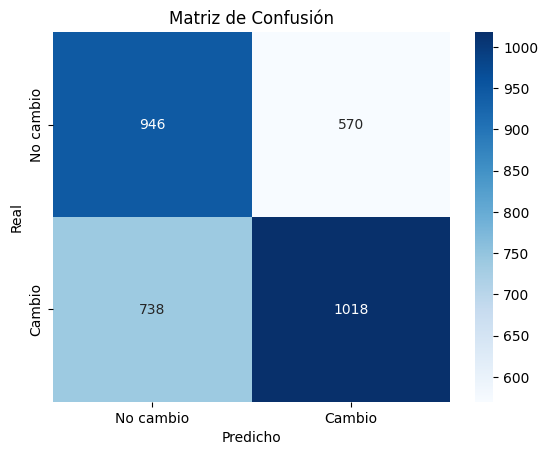

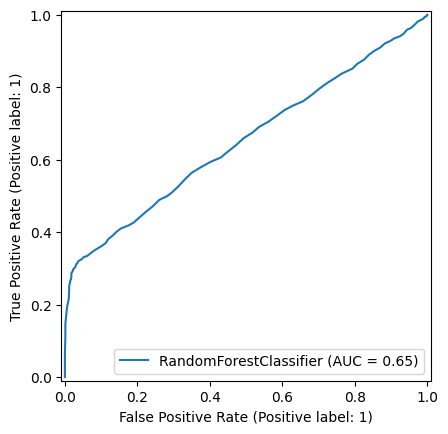


PERMUTATION IMPORTANCE:
                  feature  importance_mean  importance_std
5                sum_fact         0.101498        0.004835
6            sum_duracion         0.015923        0.007982
3                  gender         0.005868        0.004977
2                    city         0.005868        0.003479
1          country_region         0.004432        0.007195
0                platform         0.002323        0.001137
8  target_churn_indicator         0.000122        0.001320
4             range_group        -0.000122        0.002528
7    n_previous_registers        -0.001009        0.001223

T-test sum_duracion: t=-0.88, p=0.3787
Chi-cuadrado city: chi2=679.94, p=0.3761


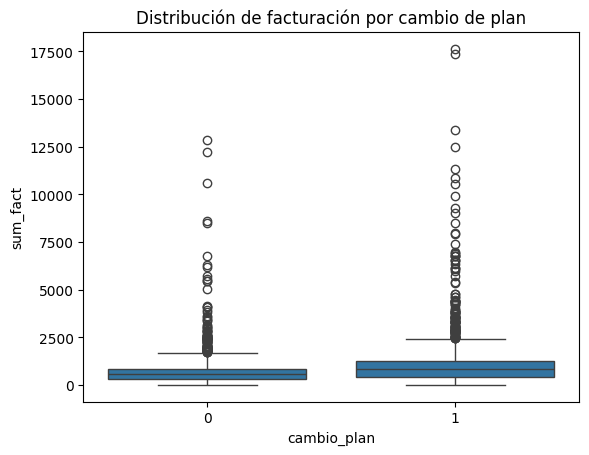


=== Tres principales características de clientes que cambian de plan ===
1. sum_fact → media cambio: 911.64, media no cambio: 614.79
2. sum_duracion → media cambio: 370.66, media no cambio: 382.01
3. gender → media cambio: 0.47, media no cambio: 0.46

Conclusión: Los clientes que cambian de plan se caracterizan principalmente por mayor sum_fact, seguido de sum_duracion y gender. La primera variable es la más predictiva según el modelo, mientras que las otras dos aportan información adicional aunque con menor peso.


In [30]:
analizador = CambioPlanAnalyzer(datasets)

analizador.preparar_datos()
analizador.preparar_features()
analizador.entrenar_modelo()
analizador.evaluar_modelo()  
analizador.calcular_permutation_importance()
analizador.pruebas_estadisticas()
analizador.graficar_distribucion()
analizador.resumen_caracteristicas()